In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hdr-datasets/English.npz
/kaggle/input/hdr-datasets/Telugu.npz
/kaggle/input/hdr-datasets/THEA.npz
/kaggle/input/hdr-datasets/Devanagari.npz
/kaggle/input/hdr-datasets/Arabic.npz


In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Sequential
%matplotlib inline
from numpy import load, savez

In [3]:
from numpy import load
data = load('/kaggle/input/hdr-datasets/THEA.npz')
x_train = data[data.files[0]]
x_test = data[data.files[1]]
y_train = data[data.files[2]]
y_test = data[data.files[3]]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((320000, 28, 28), (80000, 28, 28), (320000,), (80000,))

In [4]:
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

2023-02-01 03:31:52.409418: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
print(x_train.shape, x_test.shape, x_val.shape)

(318000, 32, 32, 3) (80000, 32, 32, 3) (2000, 32, 32, 3)


In [6]:
model = models.Sequential()
model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))
model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))
model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 256)         0

In [9]:
model.compile(optimizer='adam', 
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy']
)

history = model.fit(x_train, y_train, batch_size=64, epochs=4, validation_data=(x_val, y_val))

Epoch 1/4
4969/4969 [==============================] - 4477s 901ms/step - loss: 0.0638 - accuracy: 0.9836 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 2/4
4969/4969 [==============================] - 4492s 904ms/step - loss: 0.0470 - accuracy: 0.9878 - val_loss: 0.0247 - val_accuracy: 0.9940
Epoch 3/4
4969/4969 [==============================] - 4522s 910ms/step - loss: 0.0398 - accuracy: 0.9898 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 4/4
4969/4969 [==============================] - 4512s 908ms/step - loss: 0.0315 - accuracy: 0.9916 - val_loss: 0.0067 - val_accuracy: 0.9980


In [10]:
history.history

{'loss': [0.06381727755069733,
  0.04699939116835594,
  0.03983654826879501,
  0.03153165429830551],
 'accuracy': [0.983578622341156,
  0.9878458976745605,
  0.9898396134376526,
  0.9916352033615112],
 'val_loss': [0.001750274677760899,
  0.024655161425471306,
  0.0013941687066107988,
  0.0066902353428304195],
 'val_accuracy': [0.9994999766349792,
  0.9940000176429749,
  0.9994999766349792,
  0.9980000257492065]}

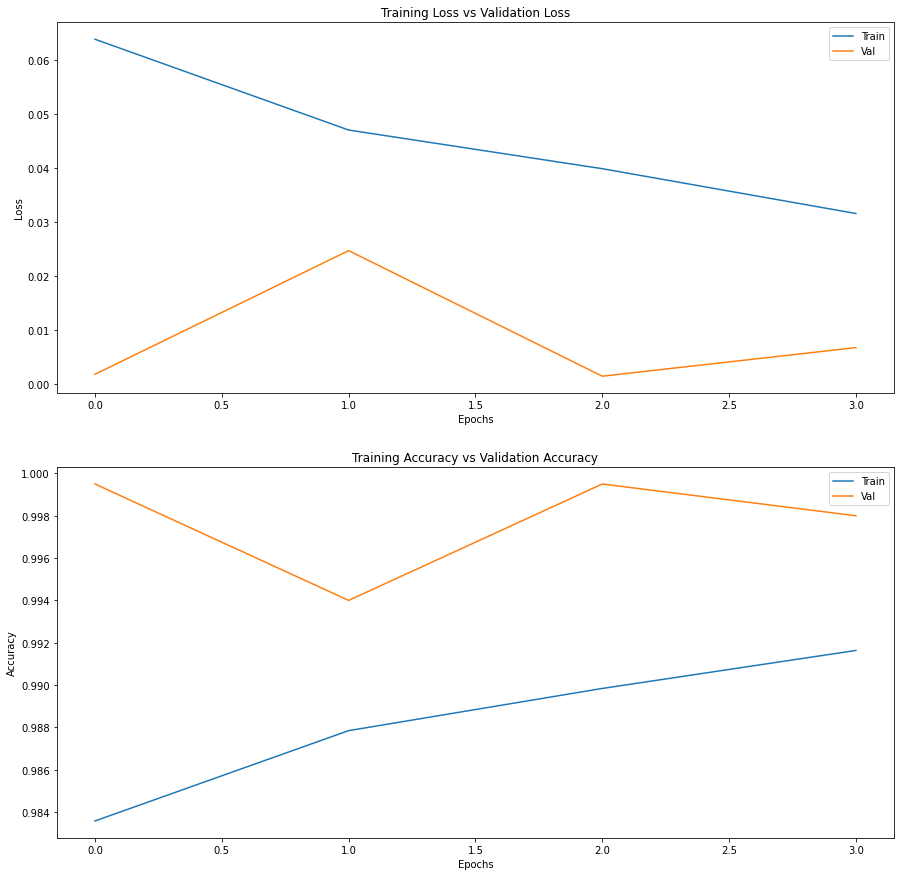

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [12]:
model.evaluate(x_test, y_test)

2500/2500 [==============================] - 531s 212ms/step - loss: 0.0648 - accuracy: 0.9827


[0.0647771954536438, 0.9826750159263611]

In [13]:
y_pred = model.predict(x_test)
y_pred_labels = [np.argmax(i) for i in y_pred]

In [14]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[7959,   31,    6,   10,   10,   12,    6,    7,    5,   18],
       [  11, 7775,    1,   13,    0,    1,    0,   14,    0,    1],
       [   4,   18, 7847,   74,   36,    0,    5,   52,    2,   14],
       [   1,    0,    1, 7843,    2,    1,    0,    5,    0,    1],
       [   0,    1,   11,    5, 8037,    0,    2,   14,    2,    4],
       [ 297,    0,    9,  144,    0, 7565,   12,    5,    5,   64],
       [   5,    9,    3,    4,    4,    8, 7988,   20,    3,    7],
       [   2,    7,    6,    5,    5,    1,   27, 7869,    2,    0],
       [  20,   18,   19,   68,   18,    1,    7,   16, 7796,   50],
       [   7,    8,    5,    5,   57,    1,   21,   10,    0, 7935]],
      dtype=int32)>

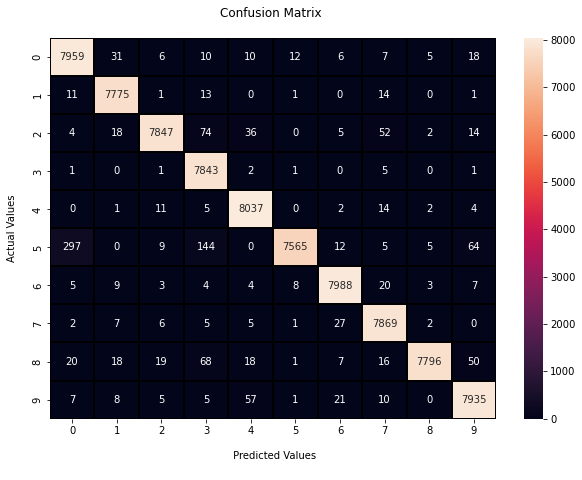

In [16]:
import seaborn as sn
plt.figure(figsize=(10,7))
fx=sn.heatmap(cm, annot=True, linewidths=0.25, fmt='d', linecolor="black")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
plt.show()

In [20]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      8064
           1       0.99      0.99      0.99      7816
           2       0.99      0.97      0.98      8052
           3       0.96      1.00      0.98      7854
           4       0.98      1.00      0.99      8076
           5       1.00      0.93      0.96      8101
           6       0.99      0.99      0.99      8051
           7       0.98      0.99      0.99      7924
           8       1.00      0.97      0.99      8013
           9       0.98      0.99      0.98      8049

    accuracy                           0.98     80000
   macro avg       0.98      0.98      0.98     80000
weighted avg       0.98      0.98      0.98     80000

